In [60]:
import pyomo.environ as pyo
from pyomo.dae import ContinuousSet, DerivativeVar
from pyomo.contrib.doe import DesignOfExperiments, MeasurementVariables, DesignVariables, ModelOptionLib
import numpy as np
from random import sample
from matplotlib import pyplot as plt

In [2]:
def create_model(
    mod=None,
    model_option="stage2",
    control_time=[0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1],
    control_val=None,
    t_range=[0.0, 1],
    CA_init=1,
    C_init=0.1,
):
    """
    This is an example user model provided to DoE library.
    It is a dynamic problem solved by Pyomo.DAE.

    Arguments
    ---------
    mod: Pyomo model. If None, a Pyomo concrete model is created
    model_option: choose from the 3 options in model_option
        if ModelOptionLib.parmest, create a process model.
        if ModelOptionLib.stage1, create the global model.
        if ModelOptionLib.stage2, add model variables and constraints for block.
    control_time: a list of control timepoints
    control_val: control design variable values T at corresponding timepoints
    t_range: time range, h
    CA_init: time-independent design (control) variable, an initial value for CA
    C_init: An initial value for C

    Return
    ------
    m: a Pyomo.DAE model
    """

    theta = {"A1": 84.79, "A2": 371.72, "E1": 7.78, "E2": 15.05}

    model_option = ModelOptionLib(model_option)

    if model_option == ModelOptionLib.parmest:
        mod = pyo.ConcreteModel()
        return_m = True
    elif model_option == ModelOptionLib.stage1 or model_option == ModelOptionLib.stage2:
        if not mod:
            raise ValueError(
                "If model option is stage1 or stage2, a created model needs to be provided."
            )
        return_m = False
    else:
        raise ValueError(
            "model_option needs to be defined as parmest,stage1, or stage2."
        )

    if not control_val:
        control_val = [300] * 9

    controls = {}
    for i, t in enumerate(control_time):
        controls[t] = control_val[i]

    mod.t0 = pyo.Set(initialize=[0])
    mod.t_con = pyo.Set(initialize=control_time)
    mod.CA0 = pyo.Var(
        mod.t0, initialize=CA_init, bounds=(1.0, 5.0), within=pyo.NonNegativeReals
    )  # mol/L

    # check if control_time is in time range
    assert (
        control_time[0] >= t_range[0] and control_time[-1] <= t_range[1]
    ), "control time is outside time range."

    if model_option == ModelOptionLib.stage1:
        mod.T = pyo.Var(
            mod.t_con,
            initialize=controls,
            bounds=(300, 700),
            within=pyo.NonNegativeReals,
        )
        return

    else:
        para_list = ["A1", "A2", "E1", "E2"]

        ### Add variables
        mod.CA_init = CA_init
        mod.para_list = para_list

        # timepoints
        mod.t = ContinuousSet(bounds=t_range, initialize=control_time)

        # time-dependent design variable, initialized with the first control value
        def T_initial(m, t):
            if t in m.t_con:
                return controls[t]
            else:
                # count how many control points are before the current t;
                # locate the nearest neighbouring control point before this t
                neighbour_t = max(tc for tc in control_time if tc < t)
                return controls[neighbour_t]

        mod.T = pyo.Var(
            mod.t, initialize=T_initial, bounds=(300, 700), within=pyo.NonNegativeReals
        )

        mod.R = 8.31446261815324  # J / K / mole

        # Define parameters as Param
        mod.A1 = pyo.Var(initialize=theta["A1"])
        mod.A2 = pyo.Var(initialize=theta["A2"])
        mod.E1 = pyo.Var(initialize=theta["E1"])
        mod.E2 = pyo.Var(initialize=theta["E2"])

        # Concentration variables under perturbation
        mod.C_set = pyo.Set(initialize=["CA", "CB", "CC"])
        mod.C = pyo.Var(
            mod.C_set, mod.t, initialize=C_init, within=pyo.NonNegativeReals
        )

        # time derivative of C
        mod.dCdt = DerivativeVar(mod.C, wrt=mod.t)

        # kinetic parameters
        def kp1_init(m, t):
            return m.A1 * pyo.exp(-m.E1 * 1000 / (m.R * m.T[t]))

        def kp2_init(m, t):
            return m.A2 * pyo.exp(-m.E2 * 1000 / (m.R * m.T[t]))

        mod.kp1 = pyo.Var(mod.t, initialize=kp1_init)
        mod.kp2 = pyo.Var(mod.t, initialize=kp2_init)

        def T_control(m, t):
            """
            T at interval timepoint equal to the T of the control time point at the beginning of this interval
            Count how many control points are before the current t;
            locate the nearest neighbouring control point before this t
            """
            if t in m.t_con:
                return pyo.Constraint.Skip
            else:
                neighbour_t = max(tc for tc in control_time if tc < t)
                return m.T[t] == m.T[neighbour_t]

        def cal_kp1(m, t):
            """
            Create the perturbation parameter sets
            m: model
            t: time
            """
            # LHS: 1/h
            # RHS: 1/h*(kJ/mol *1000J/kJ / (J/mol/K) / K)
            return m.kp1[t] == m.A1 * pyo.exp(-m.E1 * 1000 / (m.R * m.T[t]))

        def cal_kp2(m, t):
            """
            Create the perturbation parameter sets
            m: model
            t: time
            """
            # LHS: 1/h
            # RHS: 1/h*(kJ/mol *1000J/kJ / (J/mol/K) / K)
            return m.kp2[t] == m.A2 * pyo.exp(-m.E2 * 1000 / (m.R * m.T[t]))

        def dCdt_control(m, y, t):
            """
            Calculate CA in Jacobian matrix analytically
            y: CA, CB, CC
            t: timepoints
            """
            if y == "CA":
                return m.dCdt[y, t] == -m.kp1[t] * m.C["CA", t]
            elif y == "CB":
                return m.dCdt[y, t] == m.kp1[t] * m.C["CA", t] - m.kp2[t] * m.C["CB", t]
            elif y == "CC":
                return pyo.Constraint.Skip

        def alge(m, t):
            """
            The algebraic equation for mole balance
            z: m.pert
            t: time
            """
            return m.C["CA", t] + m.C["CB", t] + m.C["CC", t] == m.CA0[0]

        # Control time
        mod.T_rule = pyo.Constraint(mod.t, rule=T_control)

        # calculating C, Jacobian, FIM
        mod.k1_pert_rule = pyo.Constraint(mod.t, rule=cal_kp1)
        mod.k2_pert_rule = pyo.Constraint(mod.t, rule=cal_kp2)
        mod.dCdt_rule = pyo.Constraint(mod.C_set, mod.t, rule=dCdt_control)

        mod.alge_rule = pyo.Constraint(mod.t, rule=alge)

        # B.C.
        mod.C["CB", 0.0].fix(0.0)
        mod.C["CC", 0.0].fix(0.0)

        if return_m:
            return mod

In [3]:
def disc_for_measure(m, nfe=32, block=True):
    """Pyomo.DAE discretization

    Arguments
    ---------
    m: Pyomo model
    nfe: number of finite elements b
    block: if True, the input model has blocks
    """
    discretizer = pyo.TransformationFactory("dae.collocation")
    if block:
        for s in range(len(m.block)):
            discretizer.apply_to(m.block[s], nfe=nfe, ncp=3, wrt=m.block[s].t)
    else:
        discretizer.apply_to(m, nfe=nfe, ncp=3, wrt=m.t)
    return m

In [4]:
    # Control time set [h]
    t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    # Define parameter nominal value
    parameter_dict = {"A1": 85, "A2": 370, "E1": 8, "E2": 15}

    # Define measurement object
    measurements = MeasurementVariables()
    measurements.add_variables(
        "C",  # measurement variable name
        indices={
            0: ["CA", "CB", "CC"],
            1: t_control,
        },  # 0,1 are indices of the index sets
        time_index_position=1,
    )

    # design object
    exp_design = DesignVariables()

    # add CAO as design variable
    exp_design.add_variables(
        "CA0",  # design variable name
        indices={0: [0]},  # index dictionary
        time_index_position=0,  # time index position
        values=[5],  # design variable values
        lower_bounds=1,  # design variable lower bounds
        upper_bounds=5,  # design variable upper bounds
    )

    # add T as design variable
    exp_design.add_variables(
        "T",  # design variable name
        indices={0: t_control},  # index dictionary
        time_index_position=0,  # time index position
        values=[
            570,
            300,
            300,
            300,
            300,
            300,
            300,
            300,
            300,
        ],  # same length with t_control
        lower_bounds=300,  # design variable lower bounds
        upper_bounds=700,  # design variable upper bounds
    )

In [5]:
    doe_object = DesignOfExperiments(
        parameter_dict,  # parameter dictionary
        exp_design,  # DesignVariables object
        measurements,  # MeasurementVariables object
        create_model,  # create model function
        discretize_model=disc_for_measure,  # discretize model function
    )

    result = doe_object.compute_FIM(
        mode="sequential_finite",  # calculation mode
        scale_nominal_param_value=True,  # scale nominal parameter value
        formula="central",  # formula for finite difference
    )

    result.result_analysis()


Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

In [54]:
# Make a function that takes in experimental design and gives you a new doe object
def new_doe_object(Ca, T0):
    t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    parameter_dict = {"A1": 85, "A2": 370, "E1": 8, "E2": 15}
    
    measurements = MeasurementVariables()
    measurements.add_variables("C", indices={0: ["CA", "CB", "CC"], 1: t_control}, time_index_position=1)
    
    exp_design = DesignVariables()
    exp_design.add_variables(
        "CA0",
        time_index_position=0,
        # values=[Ca],
        lower_bounds=1,
        indices={0: [0]},
        upper_bounds=5,
    )
    exp_design.add_variables(
        "T",
        indices={0: t_control},
        time_index_position=0,
        # values=[T0]*9,
        lower_bounds=300,
        upper_bounds=700,
    )

    exp_design.update_values({"CA0[0]": Ca, "T[0]": T0, "T[0.125]": T0, "T[0.25]": T0, "T[0.375]": T0, "T[0.5]": T0, "T[0.625]": T0,
                             "T[0.75]": T0, "T[0.875]": T0, "T[1]": T0})

    prior_pass = [
    [22.52943024, 1.84034314, -70.23273336, -11.09432962],
    [1.84034314, 18.09848116, -5.73565034, -109.15866135],
    [-70.23273336, -5.73565034, 218.94192843, 34.57680848],
    [-11.09432962, -109.15866135, 34.57680848, 658.37644634]
    ]
    
    doe_object = DesignOfExperiments(
        parameter_dict,
        exp_design, 
        measurements, 
        create_model,
        prior_FIM=prior_pass,
        discretize_model=disc_for_measure,
    )

    result = doe_object.compute_FIM(
        mode="sequential_finite",
        scale_nominal_param_value=True,
        formula="central",
    )

    result.result_analysis()
    
    return result


# Discretize the experimental design space (make a linspace) for sensitivity analysis
T_vals = np.linspace(300, 700, 3)
C_vals = np.linspace(1, 5, 3)

A_opt_vals = []
D_opt_vals = []
E_opt_vals = []
ME_opt_vals = []
for i in C_vals:
    for j in T_vals:
        fims = new_doe_object(i, j)
        print(fims.FIM)
        A_opt = np.trace(fims.FIM)
        D_opt = np.linalg.det(fims.FIM)
        E_opt = min(np.linalg.eigvals(fims.FIM))
        ME_opt = np.linalg.cond(fims.FIM)
        
        A_opt_vals.append(np.log10(A_opt))
        D_opt_vals.append(np.log10(D_opt))
        E_opt_vals.append(np.log10(E_opt))
        ME_opt_vals.append(np.log10(ME_opt))

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

In [93]:
# random experiment loop
np.random.rand(1) * 4 + 1

array([4.10820024])

In [94]:
def new_doe_object2(Ca, T0, FIM_prior):
    t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    parameter_dict = {"A1": 85, "A2": 370, "E1": 8, "E2": 15}
    
    measurements = MeasurementVariables()
    measurements.add_variables("C", indices={0: ["CA", "CB", "CC"], 1: t_control}, time_index_position=1)
    
    exp_design = DesignVariables()
    exp_design.add_variables(
        "CA0",
        time_index_position=0,
        values=[Ca, ],
        lower_bounds=1,
        indices={0: [0]},
        upper_bounds=5,
    )
    exp_design.add_variables(
        "T",
        indices={0: t_control},
        time_index_position=0,
        values=list(T0),
        lower_bounds=300,
        upper_bounds=700,
    )

    # exp_design.update_values({"CA0[0]": Ca, "T[0]": T0[0], "T[0.125]": T0[1], "T[0.25]": T0[2], "T[0.375]": T0[3], "T[0.5]": T0[4], "T[0.625]": T0[5],
    #                          "T[0.75]": T0[6], "T[0.875]": T0[7], "T[1]": T0[8]})
    
    doe_object = DesignOfExperiments(
        parameter_dict,
        exp_design, 
        measurements, 
        create_model,
        # prior_FIM=FIM_prior,
        discretize_model=disc_for_measure,
    )

    result = doe_object.compute_FIM(
        mode="sequential_finite",
        scale_nominal_param_value=True,
        formula="central",
    )

    result.result_analysis()
    
    return result

n_para = len(parameter_dict)


t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
parameter_dict = {"A1": 85, "A2": 370, "E1": 8, "E2": 15}
    
measurements = MeasurementVariables()
measurements.add_variables("C", indices={0: ["CA", "CB", "CC"], 1: t_control}, time_index_position=1)
    
exp_design = DesignVariables()
exp_design.add_variables(
    "CA0",
    indices={0: [0]},
    time_index_position=0,
    lower_bounds=1,
    upper_bounds=5,
    )
exp_design.add_variables(
    "T",
    indices={0: t_control},
    time_index_position=0,
    lower_bounds=300,
    upper_bounds=700,
    )

exp_design.update_values({"CA0[0]": 5, "T[0]": 450, "T[0.125]": 300, "T[0.25]": 300, "T[0.375]": 300, "T[0.5]": 300, "T[0.625]": 300,
                             "T[0.75]": 300, "T[0.875]": 300, "T[1]": 300})
    
doe_object = DesignOfExperiments(
    parameter_dict,
    exp_design, 
    measurements, 
    create_model,
    discretize_model=disc_for_measure,
    )

result = doe_object.compute_FIM(
        mode="sequential_finite",
        scale_nominal_param_value=True,
        formula="central",
    )

result.result_analysis()

FIM_prior = result.FIM
FIM_new = np.zeros((n_para, n_para))
A_vals_rand = []
D_vals_rand = []
exp_conds_rand = []
FIM_rand = None

for i in range(20):
    FIM_prior += FIM_new
    # T_val = sample(range(300, 750, 50), 1)
    T_val = np.random.rand(9)
    T_val = 300 + (700 - 300) * T_val
    # C_val = sample([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], 1)
    C_val = np.random.rand(1)
    C_val = 1.0 + (5.0 - 1.0) * C_val
    
    new_exp = new_doe_object2(C_val[0], T_val, FIM_prior)
    FIM_new = new_exp.FIM
    if FIM_rand is None:
        FIM_rand = [FIM_new, ]
    else:
        FIM_rand.append(FIM_new)
    A_opt = np.trace(FIM_new)
    D_opt = np.linalg.det(FIM_new)
    A_vals_rand.append(np.log10(A_opt))
    D_vals_rand.append(np.log10(D_opt))

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

[array([[  7.41191972,   1.91892715, -17.16569693,  -5.13978557],
       [  1.91892715,   3.00288018,  -3.30481097,  -9.22942421],
       [-17.16569693,  -3.30481097,  40.83791667,   8.43170603],
       [ -5.13978557,  -9.22942421,   8.43170603,  29.03347955]]), array([[  4.85545081,   0.91633779, -11.26700706,  -2.3725946 ],
       [  0.91633779,   2.07545769,  -1.67466172,  -6.76212137],
       [-11.26700706,  -1.67466172,  26.48743701,   4.09255167],
       [ -2.3725946 ,  -6.76212137,   4.09255167,  22.59510839]]), array([[ 1.63712282,  0.26253947, -3.61049017, -0.64461976],
       [ 0.26253947,  0.65918137, -0.44757963, -2.18785091],
       [-3.61049017, -0.44757963,  8.05695621,  1.03503989],
       [-0.64461976, -2.18785091,  1.03503989,  7.4873944 ]]), array([[ 2.97488904,  0.93745651, -5.81666255, -3.06492446],
       [ 0.93745651,  2.37956777, -1.78533978, -8.23677851],
       [-5.81666255, -1.78533978, 11.39473346,  5.858635  ],
       [-3.06492446, -8.23677851,  5.858635  ,

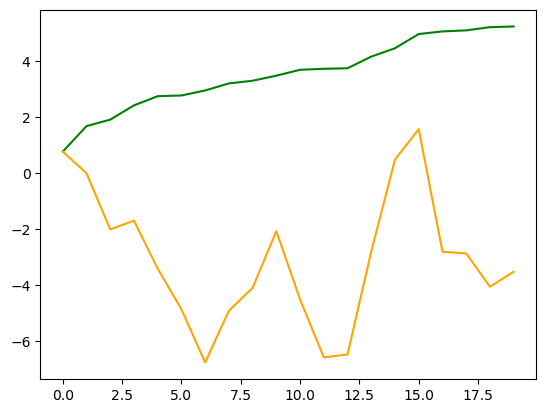

In [99]:
D_vals_rand_from_ind_FIM = []
running_FIM = np.zeros((n_para, n_para))
print(FIM_rand)
for i in range(20):
    running_FIM += FIM_rand[i]
    D_vals_rand_from_ind_FIM.append(np.log10(np.linalg.det(running_FIM)))

plt.plot(range(20), D_vals_rand_from_ind_FIM, color='green')
plt.plot(range(20), D_vals_rand, color='orange')
plt.show()

In [ ]:
# mobel based design

In [106]:
n_para = len(parameter_dict)

t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
parameter_dict = {"A1": 85, "A2": 370, "E1": 8, "E2": 15}
    
measurements = MeasurementVariables()
measurements.add_variables("C", indices={0: ["CA", "CB", "CC"], 1: t_control}, time_index_position=1)
    
exp_design = DesignVariables()
exp_design.add_variables(
    "CA0",
    indices={0: [0]},
    time_index_position=0,
    lower_bounds=1,
    upper_bounds=5,
    )
exp_design.add_variables(
    "T",
    indices={0: t_control},
    time_index_position=0,
    lower_bounds=300,
    upper_bounds=700,
    )

exp_design.update_values({"CA0[0]": 5, "T[0]": 450, "T[0.125]": 300, "T[0.25]": 300, "T[0.375]": 300, "T[0.5]": 300, "T[0.625]": 300,
                             "T[0.75]": 300, "T[0.875]": 300, "T[1]": 300})
    
doe_object = DesignOfExperiments(
    parameter_dict,
    exp_design, 
    measurements, 
    create_model,
    discretize_model=disc_for_measure,
    )

result = doe_object.compute_FIM(
        mode="sequential_finite",
        scale_nominal_param_value=True,
        formula="central",
    )

result.result_analysis()

FIM_prior = result.FIM
FIM_new = np.zeros((n_para, n_para))
A_vals = []
D_vals = []
exp_conds = []
FIM_opt = None

def get_exp_conds(m):
    return [pyo.value(m.CA0[0]), pyo.value(m.T[0]), pyo.value(m.T[0.125]), pyo.value(m.T[0.25]), pyo.value(m.T[0.375]), pyo.value(m.T[0.5]), pyo.value(m.T[0.625]), pyo.value(m.T[0.75]), pyo.value(m.T[0.875]), pyo.value(m.T[1])]

for i in range(20):
    FIM_prior += FIM_new
    
    doe_object = DesignOfExperiments(
        parameter_dict,
        exp_design, 
        measurements, 
        create_model,
        prior_FIM=FIM_prior,
        discretize_model=disc_for_measure,
    )
    
    square_result, optimize_result = doe_object.stochastic_program(
        if_optimize=True,
        if_Cholesky=True,
        scale_nominal_param_value=True,
        objective_option="det",
        L_initial=np.linalg.cholesky(FIM_prior),
    )
    FIM_new = optimize_result.FIM
        
    new_exp_conds = get_exp_conds(optimize_result.model)
    result = new_doe_object2(new_exp_conds[0], new_exp_conds[1:], FIM_new)

    if FIM_opt is None:
        FIM_opt = [result.FIM, ]
    else:
        FIM_opt.append(result.FIM)
    
    D_opt = np.linalg.det(FIM_new)
    # A_vals.append(np.log10(A_opt))
    D_vals.append(np.log10(D_opt))
    exp_conds.append(new_exp_conds)

Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for

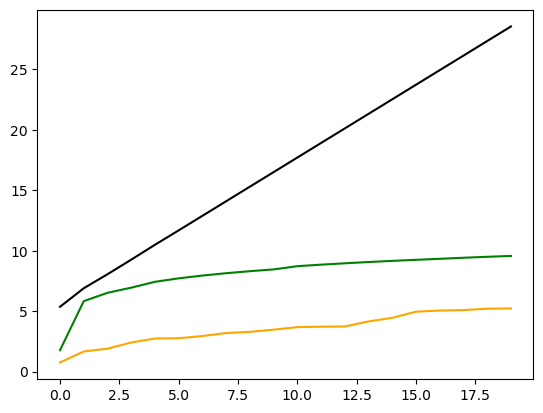

In [109]:
D_vals_opt_from_ind_FIM = []
running_FIM = np.zeros((n_para, n_para))
for i in range(20):
    running_FIM += FIM_opt[i]
    D_vals_opt_from_ind_FIM.append(np.log10(np.linalg.det(running_FIM)))

plt.plot(range(20), D_vals, color='black')
plt.plot(range(20), D_vals_opt_from_ind_FIM, color='green')
plt.plot(range(20), D_vals_rand_from_ind_FIM, color='orange')
plt.show()

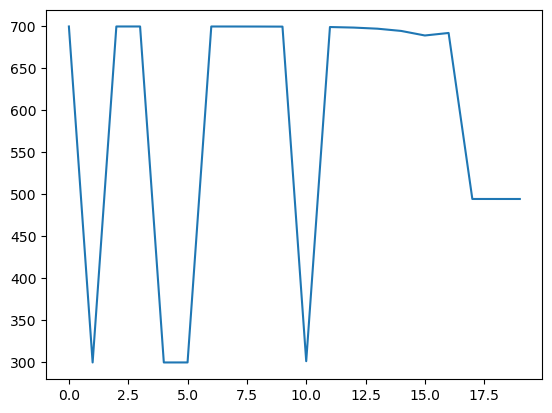

In [104]:
exp_conds_array = np.array(exp_conds)
plt.plot(range(20), exp_conds_array[:, 9])
plt.show()

INFO: =======Iteration Number: 1 =====
INFO: elapsed time: 2.2
INFO: This is run 1 out of 9.
INFO: The code has run  2.19064669997897 seconds.
INFO: Estimated remaining time:  7.667263449926395 seconds
INFO: =======Iteration Number: 2 =====
INFO: elapsed time: 1.0
INFO: This is run 2 out of 9.
INFO: The code has run  3.2144447999307886 seconds.
INFO: Estimated remaining time:  6.428889599861577 seconds
INFO: =======Iteration Number: 3 =====
INFO: elapsed time: 1.3
INFO: This is run 3 out of 9.
INFO: The code has run  4.496953599969856 seconds.
INFO: Estimated remaining time:  5.6211919999623206 seconds
INFO: =======Iteration Number: 4 =====
INFO: elapsed time: 1.0
INFO: This is run 4 out of 9.
INFO: The code has run  5.520735299913213 seconds.
INFO: Estimated remaining time:  4.4165882399305705 seconds
INFO: =======Iteration Number: 5 =====
INFO: elapsed time: 1.2
INFO: This is run 5 out of 9.
INFO: The code has run  6.751729399897158 seconds.
INFO: Estimated remaining time:  3.3758646

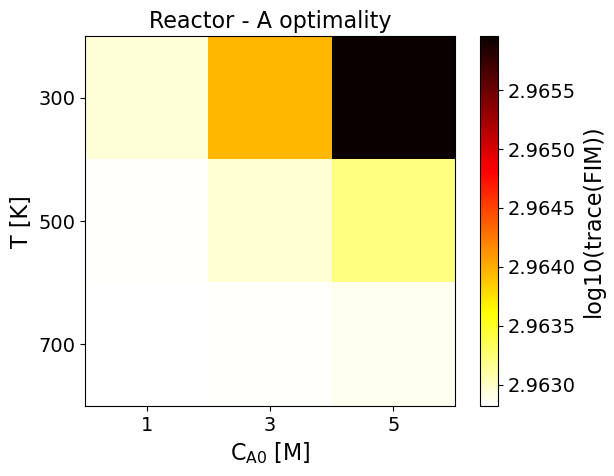

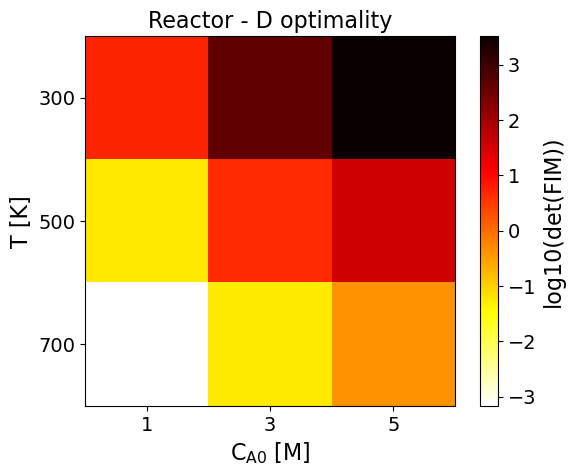

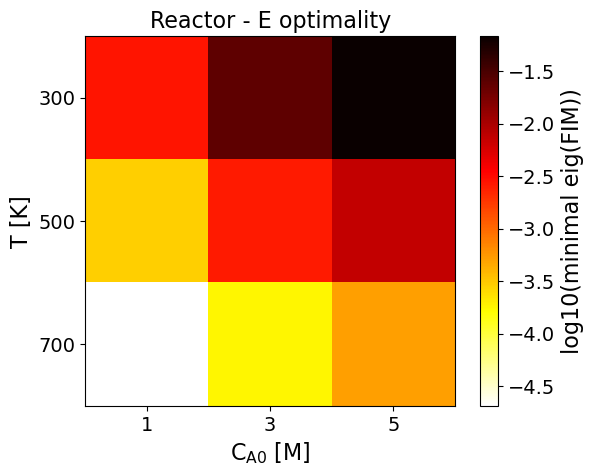

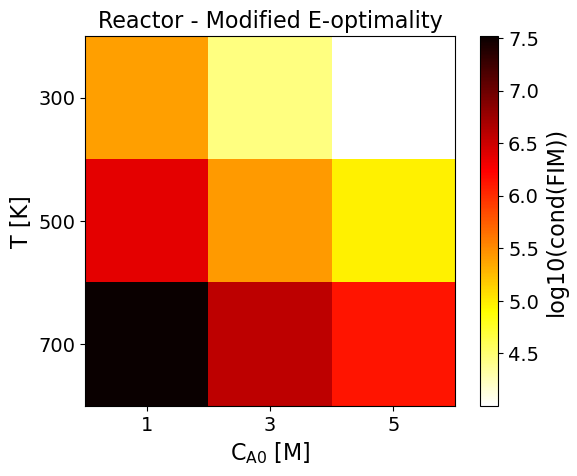

In [79]:
### Define inputs
# Control time set [h]
t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
# Define parameter nominal value
parameter_dict = {"A1": 85, "A2": 372, "E1": 8, "E2": 15}

# measurement object
measurements = MeasurementVariables()
measurements.add_variables(
    "C",  # variable name
    indices={0: ["CA", "CB", "CC"], 1: t_control},  # indices
    time_index_position=1,
)  # position of time index

# design object
exp_design = DesignVariables()

# add CAO as design variable
exp_design.add_variables(
    "CA0",  # variable name
    indices={0: [0]},  # indices
    time_index_position=0,  # position of time index
    values=[5],  # nominal value
    lower_bounds=1,  # lower bound
    upper_bounds=5,  # upper bound
)

# add T as design variable
exp_design.add_variables(
    "T",  # variable name
    indices={0: t_control},  # indices
    time_index_position=0,  # position of time index
    values=[470, 300, 300, 300, 300, 300, 300, 300, 300],  # nominal value
    lower_bounds=300,  # lower bound
    upper_bounds=700,  # upper bound
)

# For each variable, we define a list of possible values that are used
# in the sensitivity analysis

design_ranges = {
    "CA0[0]": [1, 3, 5],
    (
        "T[0]",
        "T[0.125]",
        "T[0.25]",
        "T[0.375]",
        "T[0.5]",
        "T[0.625]",
        "T[0.75]",
        "T[0.875]",
        "T[1]",
    ): [300, 500, 700],
}
## choose from "sequential_finite", "direct_kaug"
sensi_opt = "direct_kaug"

prior_pass = [
    [22.52943024, 1.84034314, -70.23273336, -11.09432962],
    [1.84034314, 18.09848116, -5.73565034, -109.15866135],
    [-70.23273336, -5.73565034, 218.94192843, 34.57680848],
    [-11.09432962, -109.15866135, 34.57680848, 658.37644634],
]

doe_object = DesignOfExperiments(
    parameter_dict,  # parameter dictionary
    exp_design,  # design variables
    measurements,  # measurement variables
    create_model,  # model function
    prior_FIM = prior_pass, 
    discretize_model=disc_for_measure,  # discretization function
)
# run full factorial grid search
all_fim = doe_object.run_grid_search(design_ranges, mode=sensi_opt)

all_fim.extract_criteria()

for i in all_fim.store_all_results_dataframe.columns:
    all_fim.store_all_results_dataframe[i] = all_fim.store_all_results_dataframe[i].values.real


fixed = {}
all_fim.figure_drawing(
    fixed, 
    ["CA0[0]","T[0]"],
    "Reactor",
    "$C_{A0}$ [M]",
    "T [K]"
)



INFO: =======Iteration Number: 1 =====
INFO: elapsed time: 0.7
INFO: This is run 1 out of 8.
INFO: The code has run  0.7312748000040301 seconds.
INFO: Estimated remaining time:  2.1938244000120903 seconds
INFO: =======Iteration Number: 2 =====
INFO: elapsed time: 0.8
INFO: This is run 2 out of 8.
INFO: The code has run  1.5368452000038815 seconds.
INFO: Estimated remaining time:  2.5614086666731355 seconds
INFO: =======Iteration Number: 3 =====
INFO: elapsed time: 0.8
INFO: This is run 3 out of 8.
INFO: The code has run  2.300336200009042 seconds.
INFO: Estimated remaining time:  2.300336200009042 seconds
INFO: =======Iteration Number: 4 =====
INFO: elapsed time: 1.0
INFO: This is run 4 out of 8.
INFO: The code has run  3.2964527000076487 seconds.
INFO: Estimated remaining time:  1.9778716200045894 seconds
INFO: =======Iteration Number: 5 =====
INFO: elapsed time: 0.7
INFO: This is run 5 out of 8.
INFO: The code has run  3.9811715000105323 seconds.
INFO: Estimated remaining time:  1.32

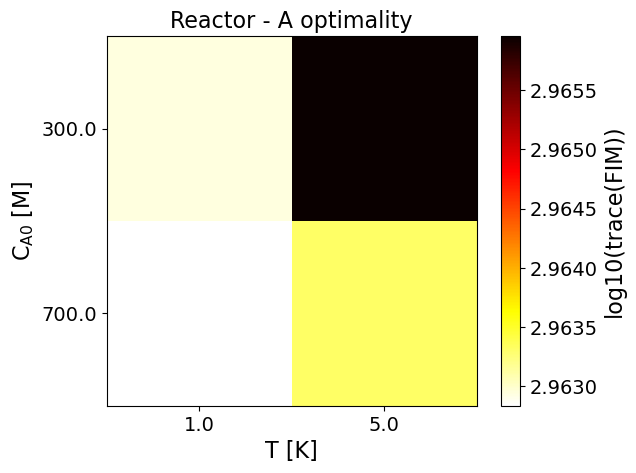

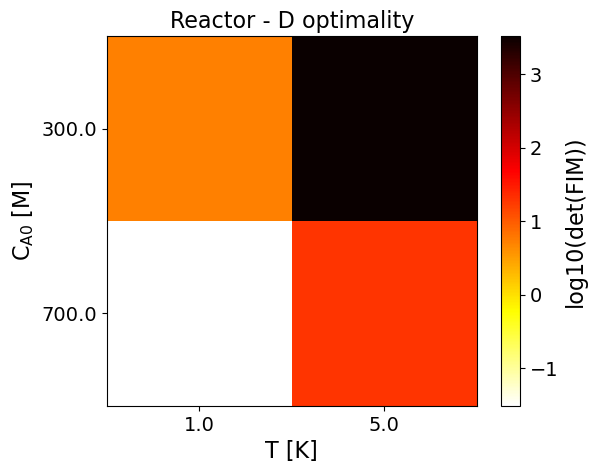

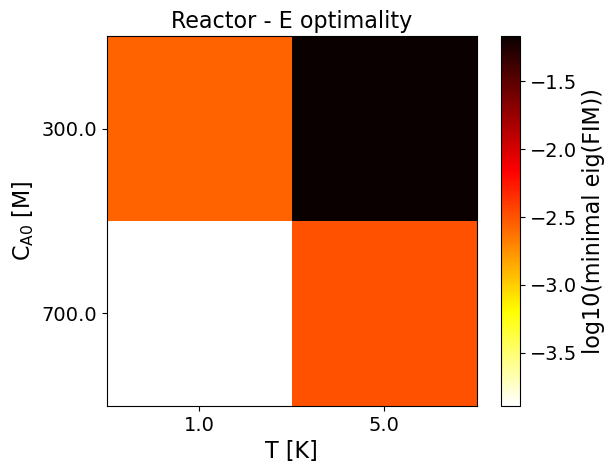

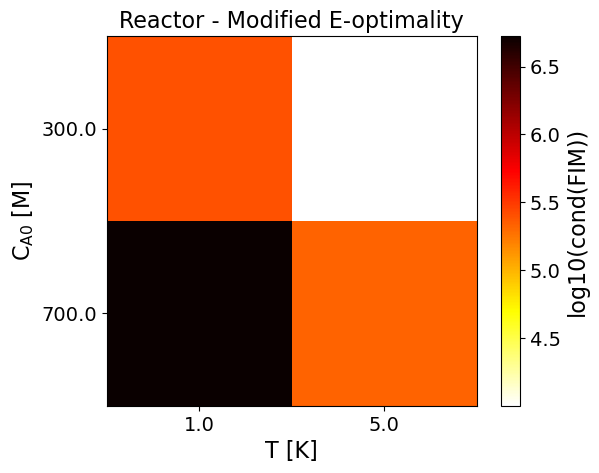

In [33]:
 ### 3 design variable example
# Define design ranges
design_ranges = {
    "CA0[0]": list(np.linspace(1, 5, 2)),
    "T[0]": list(np.linspace(300, 700, 2)),
    (
        "T[0.125]",
        "T[0.25]",
        "T[0.375]",
        "T[0.5]",
        "T[0.625]",
        "T[0.75]",
        "T[0.875]",
        "T[1]",
    ): [300, 500],
}

sensi_opt = "direct_kaug"

doe_object = DesignOfExperiments(
    parameter_dict,  # parameter dictionary
    exp_design,  # design variables
    measurements,  # measurement variables
    create_model,  # model function
    prior_FIM = prior_pass, 
    discretize_model=disc_for_measure,  # discretization function
)
# run the grid search for 3 dimensional case
all_fim = doe_object.run_grid_search(design_ranges, mode=sensi_opt)

all_fim.extract_criteria()

# see the criteria values
all_fim.store_all_results_dataframe



fixed = {"('T[0.125]', 'T[0.25]', 'T[0.375]', 'T[0.5]', 'T[0.625]', 'T[0.75]', 'T[0.875]','T[1]')": 300}

all_fim.figure_drawing(
    fixed, 
    ["CA0[0]","T[0]"],
    "Reactor", 
    "T [K]", 
    "$C_{A0}$ [M]"
)